# Analyse bivariée: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )




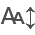

In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [25]:
## define SPARQL enpoint
endpoint = "https://ag132kz7jrzck2hf.allegrograph.cloud/repositories/peace/sparql"

In [26]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            ( GROUP_CONCAT(DISTINCT ?genderLabel; separator=", ") AS ?genders ) 
            ( GROUP_CONCAT(DISTINCT ?countryLabel; separator=", ") AS ?countries )
            ( GROUP_CONCAT(DISTINCT ?continentLabel; separator=", ") AS ?continents )
            ( GROUP_CONCAT(DISTINCT ?occupationLabel; separator=", ") AS ?occupations )
            ( GROUP_CONCAT(DISTINCT ?fieldLabel; separator=", ") AS ?fields )
WHERE {
    GRAPH <https://github.com/Raphix93/2HS2179_militants-pour-la-paix/blob/main/wikidata/graph/imported-data.md>
        {?s wdt:P21 ?gender;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?gender rdfs:label ?genderLabel.
        ?country rdfs:label ?countryLabel.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        OPTIONAL {  ?s wdt:P106 ?occupation.
                    ?occupation rdfs:label ?occupationLabel.}
        OPTIONAL {  ?s wdt:P101 ?field.
                    ?field rdfs:label ?fieldLabel.}

        ## Excluding Australia and Oceania insular
        # Eurasia : wd:Q5401 
        FILTER ( ?continent NOT IN ( wd:Q3960, wd:Q538))
          }
}
GROUP BY ?s
"""

In [27]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [28]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

901


[['http://www.wikidata.org/entity/Q450295',
  'Alyn Ware',
  '1962',
  'male',
  'New Zealand',
  'Oceania',
  'peace activist, jurist',
  ''],
 ['http://www.wikidata.org/entity/Q4537102',
  'Sahabzada Yaqub Khan',
  '1920',
  'male',
  'British Raj, Pakistan',
  'Asia',
  'peace activist, linguist, politician, military personnel, lawyer',
  ''],
 ['http://www.wikidata.org/entity/Q104183',
  'Lillian Gish',
  '1893',
  'female',
  'United States',
  'North America',
  'autobiographer, peace activist, director, film director, actor, screenwriter',
  '']]

In [29]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations', 'fields']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q450295,Alyn Ware,1962,male,New Zealand,Oceania,"peace activist, jurist",
1,http://www.wikidata.org/entity/Q4537102,Sahabzada Yaqub Khan,1920,male,"British Raj, Pakistan",Asia,"peace activist, linguist, politician, military...",
2,http://www.wikidata.org/entity/Q104183,Lillian Gish,1893,female,United States,North America,"autobiographer, peace activist, director, film...",
3,http://www.wikidata.org/entity/Q12409970,Natan Hofshi,1889,male,"Poland, Israel","Europe, Asia","peace activist, zionist, farmer",
4,http://www.wikidata.org/entity/Q113541898,Bernadette Cattanéo,1899,female,France,Europe,"women's rights activist, peace activist",


In [30]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [31]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    901 non-null    object
 1   personLabel  901 non-null    object
 2   birthYear    901 non-null    int64 
 3   gender       901 non-null    object
 4   countries    901 non-null    object
 5   continents   901 non-null    object
 6   occupations  901 non-null    object
 7   fields       901 non-null    object
dtypes: int64(1), object(7)
memory usage: 56.4+ KB


In [32]:
### Store to CSV
f_path = 'data/df_continent_occupations_fields_20250603.csv'
df_p.to_csv(f_path)

## Coder les continents et afficher leur distribution

In [33]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0          Oceania
1             Asia
2    North America
3     Europe, Asia
4           Europe
Name: continents, dtype: object


In [34]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                         0
continents                
North America          370
Europe                 305
Asia                   116
Oceania                 47
Africa                  18
Europe, North America    9
South America            9
Europe, Asia             5
Asia, Europe             4
Asia, North America      3


In [35]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'    
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [36]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [37]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q450295,Alyn Ware,1962,male,New Zealand,Oceania,"peace activist, jurist",,Oceania
1,http://www.wikidata.org/entity/Q4537102,Sahabzada Yaqub Khan,1920,male,"British Raj, Pakistan",Asia,"peace activist, linguist, politician, military...",,Asia
2,http://www.wikidata.org/entity/Q104183,Lillian Gish,1893,female,United States,North America,"autobiographer, peace activist, director, film...",,NorthAmerica


In [38]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Eurasia              8
SouthAmerica         9
Africa              18
Oceania             48
Asia               116
Europe             325
NorthAmerica       377


In [39]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
21,http://www.wikidata.org/entity/Q195390,Alexander Berkman,1870,male,"Soviet Union, Russian Empire, Russia, France, ...","Asia, Europe, North America, Eurasia","autobiographer, peace activist, journalist, wr...",,Europe
23,http://www.wikidata.org/entity/Q123625822,Q123625822,1997,male,Russia,Europe,peace activist,,Europe
59,http://www.wikidata.org/entity/Q106511833,Daria Serenko,1993,female,Russia,Europe,"poet, women's rights activist, peace activist,...",,Europe
153,http://www.wikidata.org/entity/Q51094,Yuri Shevchuk,1957,male,"Russia, Soviet Union","Europe, Asia","poet, composer, actor, peace activist, manufac...",,Eurasia
170,http://www.wikidata.org/entity/Q514820,Mollie Steimer,1897,female,"Soviet Union, Russian Empire, Mexico","Asia, Europe, North America, Eurasia","peace activist, writer, photographer",,Europe
234,http://www.wikidata.org/entity/Q2291920,Khassan Baiev,1963,male,"Russia, United States, Soviet Union","Europe, North America, Asia","autobiographer, peace activist, human rights a...",,Europe
581,http://www.wikidata.org/entity/Q2866896,Viktor Popkov,1946,male,"Russia, Soviet Union","Europe, Asia","peace activist, journalist, human rights activist",,Eurasia


In [40]:
 
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



          effectif
contCode          
Eurasia          3
Europe          13


In [41]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
97,http://www.wikidata.org/entity/Q95472072,Visaka Dharmadasa,1960,female,Sri Lanka,Asia,peace activist,,Asia
98,http://www.wikidata.org/entity/Q5704606,Jimmy Dore,1965,male,United States,North America,peace activist,,NorthAmerica
99,http://www.wikidata.org/entity/Q3017756,David Dellinger,1915,male,United States,North America,"pacifist, trade unionist, peace activist, poli...","activism, pacifism",NorthAmerica
100,http://www.wikidata.org/entity/Q124630201,Suchart Kosolkitiwong,1943,male,Thailand,Asia,"writer, peace activist, monk",,Asia


In [42]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
111,http://www.wikidata.org/entity/Q459310,Hamid Dabashi,1951,male,Iran,Asia,"peace activist, journalist, historian, professor",,Asia
112,http://www.wikidata.org/entity/Q1699788,John Dear,1959,male,United States,North America,"spiritual teacher, religious writer, peace act...",,NorthAmerica
113,http://www.wikidata.org/entity/Q6303448,Judith Hand,1940,female,United States,North America,peace activist,,NorthAmerica
114,http://www.wikidata.org/entity/Q5045212,Caroline Sarah Low,1876,female,New Zealand,Oceania,"peace activist, teacher",,Oceania
115,http://www.wikidata.org/entity/Q2193561,Kees Vellekoop,1952,male,Kingdom of the Netherlands,Europe,peace activist,,Europe
116,http://www.wikidata.org/entity/Q2674942,David Brodman,1936,male,Israel,Asia,peace activist,,Asia
117,http://www.wikidata.org/entity/Q550629,Lyndon LaRouche,1922,male,United States,North America,"politician, economist, peace activist, politic...",politics,NorthAmerica


In [43]:
### Personnes trouvées grâce à leur champ, 'field'
# https://stackoverflow.com/questions/21055068/reversal-of-string-contains-in-python-pandas
dff = df_p[~(df_p.occupations.str.contains("astronomer|physicist"))]
print('Effectif: ', len(dff), '\n')
print(dff.head(2).personUri)
dff.head()

Effectif:  892 

0     http://www.wikidata.org/entity/Q450295
1    http://www.wikidata.org/entity/Q4537102
Name: personUri, dtype: object


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q450295,Alyn Ware,1962,male,New Zealand,Oceania,"peace activist, jurist",,Oceania
1,http://www.wikidata.org/entity/Q4537102,Sahabzada Yaqub Khan,1920,male,"British Raj, Pakistan",Asia,"peace activist, linguist, politician, military...",,Asia
2,http://www.wikidata.org/entity/Q104183,Lillian Gish,1893,female,United States,North America,"autobiographer, peace activist, director, film...",,NorthAmerica
3,http://www.wikidata.org/entity/Q12409970,Natan Hofshi,1889,male,"Poland, Israel","Europe, Asia","peace activist, zionist, farmer",,Eurasia
4,http://www.wikidata.org/entity/Q113541898,Bernadette Cattanéo,1899,female,France,Europe,"women's rights activist, peace activist",,Europe


### Distribution des continents: représentation graphique

In [44]:
### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']

df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Eurasia,8,0.89
SouthAmerica,9,1.00
Africa,18,2.00
Oceania,48,5.33
Asia,116,12.87
Europe,325,36.07
NorthAmerica,377,41.84


In [45]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,NorthAmerica,Europe,Asia,Oceania,Africa,SouthAmerica,Eurasia
frequence,41.84,36.07,12.87,5.33,2.0,1.0,0.89


In [46]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#E3D4AD",  # Desert Sand : Eurasia
    "#A3C1DA",  # Light Blue : Africa    

]


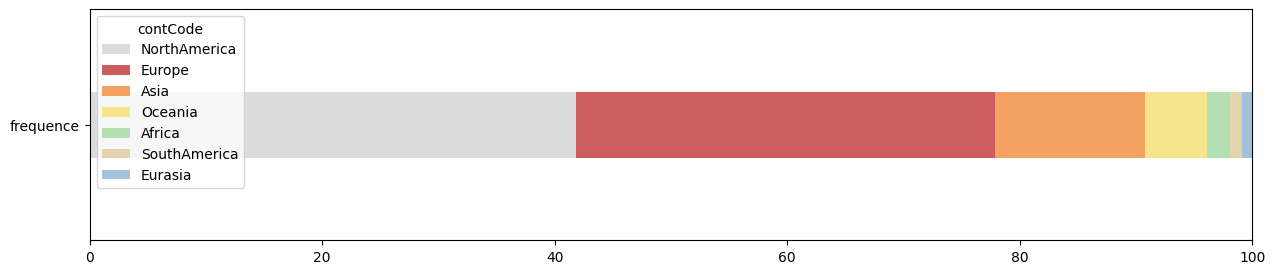

In [47]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [49]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1800, 2000, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1800, 1825, 1850, 1875, 1900] [1875, 1900, 1925, 1950, 1975] 7


In [50]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [51]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q450295,Alyn Ware,1962,male,New Zealand,Oceania,"peace activist, jurist",,Oceania,1950-1974
1,http://www.wikidata.org/entity/Q4537102,Sahabzada Yaqub Khan,1920,male,"British Raj, Pakistan",Asia,"peace activist, linguist, politician, military...",,Asia,1900-1924
2,http://www.wikidata.org/entity/Q104183,Lillian Gish,1893,female,United States,North America,"autobiographer, peace activist, director, film...",,NorthAmerica,1875-1899


In [52]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1800-1824     13
1825-1849     22
1850-1874     76
1875-1899    154
1900-1924    172
1925-1949    247
1950-1974    164
dtype: int64


### Comparer période et continent

In [53]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1800-1824,0,0,0,5,8,0,0,13
1825-1849,0,0,0,14,7,1,0,22
1850-1874,0,1,2,51,20,1,1,76
1875-1899,0,9,1,73,60,11,0,154
1900-1924,1,22,0,56,80,11,2,172
1925-1949,3,42,2,71,113,15,1,247
1950-1974,8,26,2,44,73,8,3,164
Total,12,100,7,314,361,47,7,848


In [54]:
### Modifiy column order
print(ddf.columns.to_list())
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf

['Africa', 'Asia', 'Eurasia', 'Europe', 'NorthAmerica', 'Oceania', 'SouthAmerica', 'Total']


contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1800-1824,5,0,8,0,0,0,0,13
1825-1849,14,0,7,0,0,1,0,22
1850-1874,51,2,20,1,0,1,1,76
1875-1899,73,1,60,9,0,11,0,154
1900-1924,56,0,80,22,1,11,2,172
1925-1949,71,2,113,42,3,15,1,247
1950-1974,44,2,73,26,8,8,3,164
Total,314,7,361,100,12,47,7,848


In [55]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


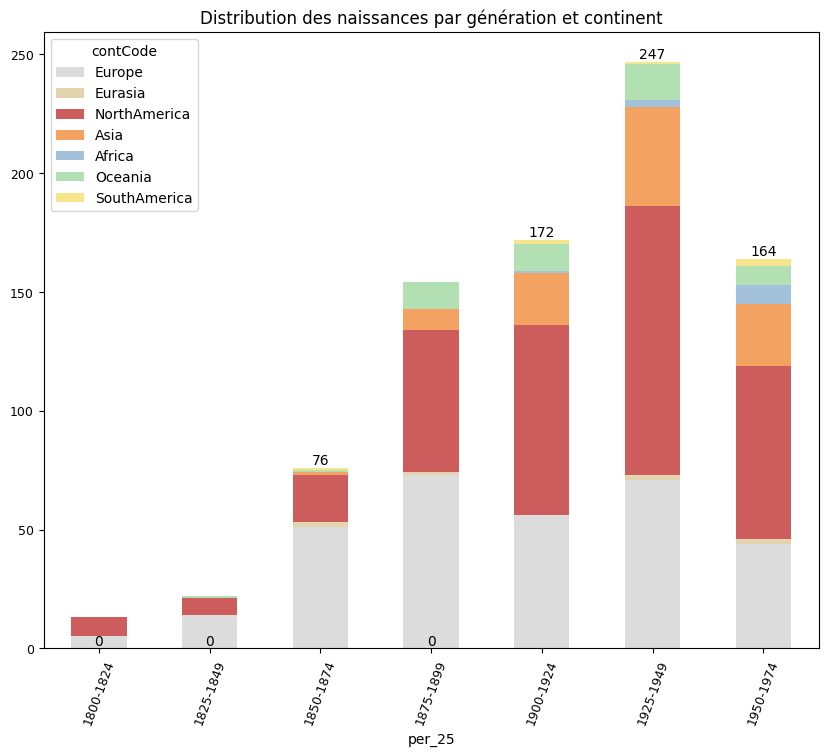

In [56]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Analyse bivariée: périodes, continents



On observe un fort déséquilibre entre les périodes et les continents. On peut présenter ce fait, par exemple en relevant le développement des États Unis et de la Russie (Eurasie) dès le milieu du 19e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants.



In [57]:
ddf

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1800-1824,5,0,8,0,0,0,0,13
1825-1849,14,0,7,0,0,1,0,22
1850-1874,51,2,20,1,0,1,1,76
1875-1899,73,1,60,9,0,11,0,154
1900-1924,56,0,80,22,1,11,2,172
1925-1949,71,2,113,42,3,15,1,247
1950-1974,44,2,73,26,8,8,3,164
Total,314,7,361,100,12,47,7,848


In [58]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddf.iloc[3:10,:-1].copy(deep=True)
D



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1875-1899,73,1,60,9,0,11,0
1900-1924,56,0,80,22,1,11,2
1925-1949,71,2,113,42,3,15,1
1950-1974,44,2,73,26,8,8,3
Total,314,7,361,100,12,47,7


In [59]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 5 , 7 ), effectif: 1585 , nombre max. facteurs: 4


In [60]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 49.31 , dof : 24
p-value : 0.001731113992500673
phi2 = inertie (variance totale) : 0.031110961140369195
Cramer:  0.0881914978050169


In [61]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1875-1899,54,1,67,19,2,9,1
1900-1924,61,1,75,22,3,10,1
1925-1949,87,2,107,31,4,14,2
1950-1974,58,1,71,21,2,10,1
Total,299,6,368,106,13,49,7


In [62]:
D

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1875-1899,73,1,60,9,0,11,0
1900-1924,56,0,80,22,1,11,2
1925-1949,71,2,113,42,3,15,1
1950-1974,44,2,73,26,8,8,3
Total,314,7,361,100,12,47,7


In [63]:


### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))



contCode   Europe  Eurasia  NorthAmerica  Asia  Africa  Oceania  SouthAmerica
per_25                                                                       
1875-1899      19        0            -7   -10      -2        2            -1
1900-1924      -5       -1             5     0      -2        1             1
1925-1949     -16        0             6    11      -1        1            -1
1950-1974     -14        1             2     5       6       -2             2
Total          15        1            -7    -6      -1       -2             0


In [64]:


### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1875-1899,2.55,-0.15,-0.83,-2.35,-1.53,0.69,-1.12
1900-1924,-0.59,-1.14,0.63,0.09,-0.99,0.32,0.50
1925-1949,-1.71,0.10,0.57,1.97,-0.38,0.18,-0.72
1950-1974,-1.81,0.68,0.23,1.19,3.50,-0.49,1.43
Total,0.89,0.23,-0.34,-0.63,-0.23,-0.32,0.02


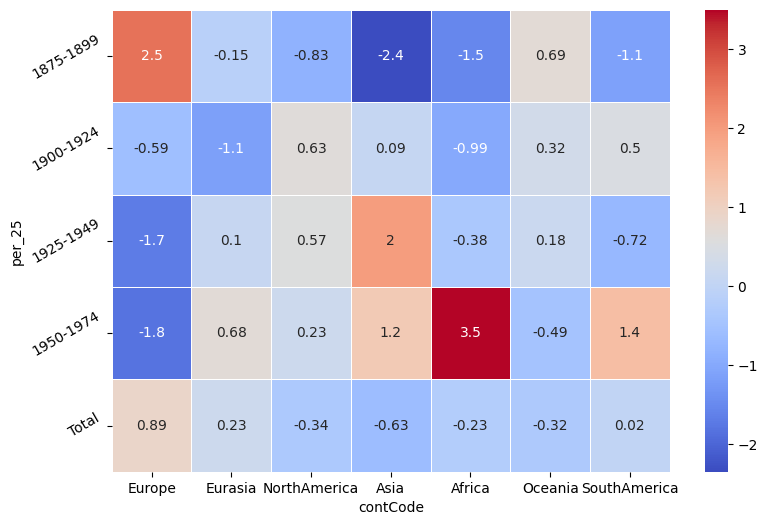

In [65]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()



### En excluant l'Europe ou choisissant les pays

In [66]:
print(D.columns.to_list())
D.iloc[ : , 1:]

['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica']


contCode,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,
1875-1899,1,60,9,0,11,0
1900-1924,0,80,22,1,11,2
1925-1949,2,113,42,3,15,1
1950-1974,2,73,26,8,8,3
Total,7,361,100,12,47,7


In [67]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 27.42 , dof : 20
p-value : 0.12385821694040151
phi2 = inertie (variance totale) : 0.017299624815020773
Cramer:  0.08169919136962027


In [68]:
D[['Europe', 'Asia', 'Eurasia', 'NorthAmerica', 'SouthAmerica']]

contCode,Europe,Asia,Eurasia,NorthAmerica,SouthAmerica
per_25,,,,,
1875-1899,73,9,1,60,0
1900-1924,56,22,0,80,2
1925-1949,71,42,2,113,1
1950-1974,44,26,2,73,3
Total,314,100,7,361,7


In [69]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D[['Europe', 'Eurasia']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D[['Europe', 'Eurasia']], method='cramer')
print('Cramer: ', vc)

Chi2 : 2.68 , dof : 4
p-value : 0.6123127873272068
phi2 = inertie (variance totale) : 0.0016923123068355848
Cramer:  0.06859894897581646


## Continent et genre

In [70]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q450295,Alyn Ware,1962,male,New Zealand,Oceania,"peace activist, jurist",,Oceania,1950-1974
1,http://www.wikidata.org/entity/Q4537102,Sahabzada Yaqub Khan,1920,male,"British Raj, Pakistan",Asia,"peace activist, linguist, politician, military...",,Asia,1900-1924
2,http://www.wikidata.org/entity/Q104183,Lillian Gish,1893,female,United States,North America,"autobiographer, peace activist, director, film...",,NorthAmerica,1875-1899
3,http://www.wikidata.org/entity/Q12409970,Natan Hofshi,1889,male,"Poland, Israel","Europe, Asia","peace activist, zionist, farmer",,Eurasia,1875-1899
4,http://www.wikidata.org/entity/Q113541898,Bernadette Cattanéo,1899,female,France,Europe,"women's rights activist, peace activist",,Europe,1875-1899


In [71]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,11,42,1,159,116,25,7,361
male,7,74,7,165,261,23,2,539
Total,18,116,8,324,377,48,9,900


### Créer la fonction

In [73]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

In [74]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddgc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
gender,,,,,,,
female,11,42,1,159,116,25,7
male,7,74,7,165,261,23,2


Chi2 : 39.29 , dof : 6
p-value : 6.278130418295044e-07
phi2 = inertie (variance totale) : 0.024788875458792534
Cramer:  0.20894009668426278


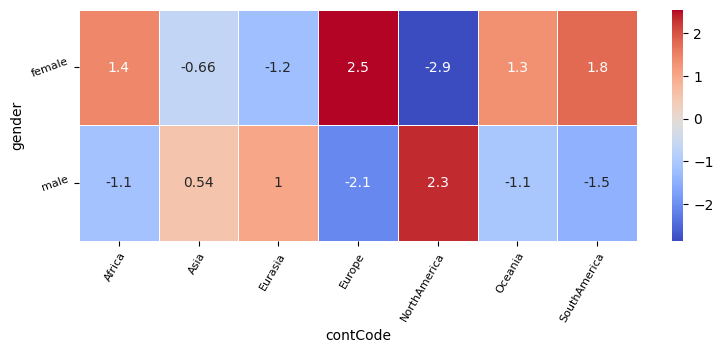

In [75]:
bivariee_stats(D)

### Genre et continent par époque

In [76]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q450295,Alyn Ware,1962,male,New Zealand,Oceania,"peace activist, jurist",,Oceania,1950-1974,Oceania_male
1,http://www.wikidata.org/entity/Q4537102,Sahabzada Yaqub Khan,1920,male,"British Raj, Pakistan",Asia,"peace activist, linguist, politician, military...",,Asia,1900-1924,Asia_male
2,http://www.wikidata.org/entity/Q104183,Lillian Gish,1893,female,United States,North America,"autobiographer, peace activist, director, film...",,NorthAmerica,1875-1899,NorthAmerica_female
3,http://www.wikidata.org/entity/Q12409970,Natan Hofshi,1889,male,"Poland, Israel","Europe, Asia","peace activist, zionist, farmer",,Eurasia,1875-1899,Eurasia_male
4,http://www.wikidata.org/entity/Q113541898,Bernadette Cattanéo,1899,female,France,Europe,"women's rights activist, peace activist",,Europe,1875-1899,Europe_female


In [77]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male,Total
per_25,,,,,,,,,,,,,,,
1800-1824,0,0,0,0,0,0,1,4,2,6,0,0,0,0,13
1825-1849,0,0,0,0,0,0,7,7,3,4,1,0,0,0,22
1850-1874,0,0,0,1,1,1,37,14,10,10,0,1,1,0,76
1875-1899,0,0,2,7,0,1,40,33,19,41,7,4,0,0,154
1900-1924,0,1,7,15,0,0,23,33,23,57,7,4,2,0,172
1925-1949,0,3,16,26,0,2,23,47,32,81,9,6,1,0,246
1950-1974,6,2,9,17,0,2,20,24,24,49,1,7,1,2,164
Total,6,6,34,66,1,6,151,162,113,248,25,22,5,2,847


In [82]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[4:-1,:-1].copy(deep=True)
D


genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male
per_25,,,,,,,,,,,,,,
1900-1924,0,1,7,15,0,0,23,33,23,57,7,4,2,0
1925-1949,0,3,16,26,0,2,23,47,32,81,9,6,1,0
1950-1974,6,2,9,17,0,2,20,24,24,49,1,7,1,2


In [83]:
## Appliquer la fonction
bivariee_stats(D)

ValueError: The internally computed table of expected frequencies has a zero element at (0, 4).

#### Explorer les résultats et commenter

In [84]:
df_pef = df_p[df_p['genre_cont'] == 'Europe_female']
print(len(df_pef))

159


In [85]:
print(df_pef.groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
United Kingdom                                                 25
Sweden                                                         19
Kingdom of the Netherlands                                     13
Kingdom of Denmark                                             10
United Kingdom of Great Britain and Ireland, United Kingdom     7
Germany                                                         7
France                                                          7
Norway                                                          6
United Kingdom of Great Britain and Ireland                     5
Switzerland                                                     5
dtype: int64


In [88]:
print(df_pef[df_pef.per_25 == '1800-2000'].groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

Series([], dtype: int64)


In [93]:
fff = df_pef[(df_pef.per_25 == '1800-2000') & (df_pef.countries.str.contains('France'))]
print(len(fff))
fff.head()

0


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont


## Continent et discipline

In [94]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q450295,Alyn Ware,1962,male,New Zealand,Oceania,"peace activist, jurist",,Oceania,1950-1974,Oceania_male
1,http://www.wikidata.org/entity/Q4537102,Sahabzada Yaqub Khan,1920,male,"British Raj, Pakistan",Asia,"peace activist, linguist, politician, military...",,Asia,1900-1924,Asia_male
2,http://www.wikidata.org/entity/Q104183,Lillian Gish,1893,female,United States,North America,"autobiographer, peace activist, director, film...",,NorthAmerica,1875-1899,NorthAmerica_female
3,http://www.wikidata.org/entity/Q12409970,Natan Hofshi,1889,male,"Poland, Israel","Europe, Asia","peace activist, zionist, farmer",,Eurasia,1875-1899,Eurasia_male
4,http://www.wikidata.org/entity/Q113541898,Bernadette Cattanéo,1899,female,France,Europe,"women's rights activist, peace activist",,Europe,1875-1899,Europe_female


In [92]:
def code_discipline(col1, col2):
    if  'astronomer' in col1\
        or 'astronomy' in col2:
        output = 'astronomy'
    elif 'physicist' in col1\
        or 'physics' in col2:
        output = 'physics'
    else:
        output = 'other'
    return output    


In [5]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.occupations, x.fields), axis=1)
df_p.head()

NameError: name 'df_p' is not defined

In [64]:
df_p.groupby('code_discipline').size()

code_discipline
astronomy     5811
physics      17873
dtype: int64

In [6]:


### Tableau de contingence
X = "contCode"
Y = "occupations"  # "0"

dddc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



NameError: name 'df_p' is not defined

In [66]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
astronomy,0.8,8.3,5.6,57.6,23.8,1.8,2.1,100.0
physics,0.6,8.8,10.1,61.4,16.6,1.1,1.5,100.0
Total,0.6,8.7,9.0,60.5,18.4,1.3,1.6,100.0


In [67]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


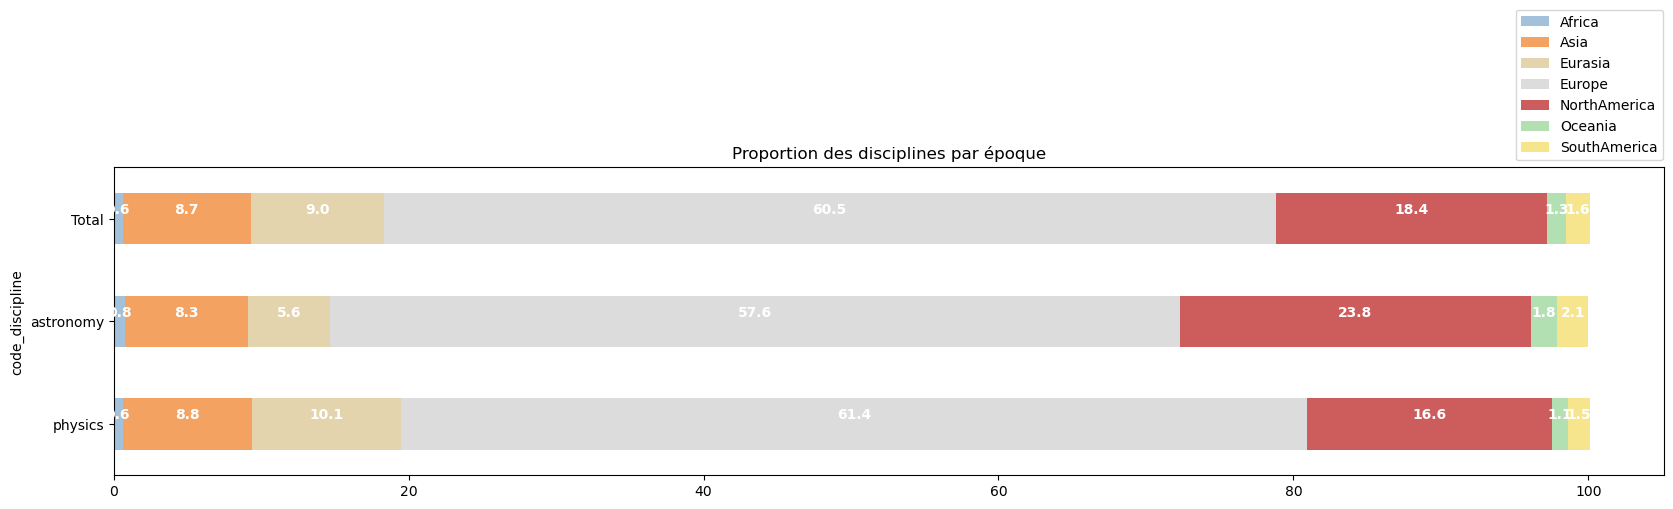

In [76]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,4), title='Proportion des disciplines par époque',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [69]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
code_discipline,,,,,,,
astronomy,45,481,323,3343,1383,105,121
physics,105,1571,1798,10967,2964,195,268


Chi2 : 265.03 , dof : 6
p-value : 2.5047376949356848e-54
phi2 = inertie (variance totale) : 0.01174273585793133
Cramer:  0.10581822458547405


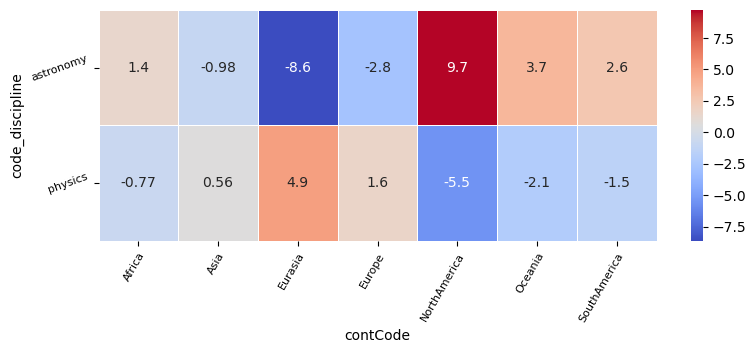

In [70]:
## Appliquer la fonction
bivariee_stats(D)

## Discipline et continent par époque

In [71]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,,Eurasia,1926-1950,Eurasia_male,physics
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",,NorthAmerica,1951-1975,NorthAmerica_female,physics


In [72]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,,Eurasia,1926-1950,Eurasia_male,physics,Eurasia_physics
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",,NorthAmerica,1951-1975,NorthAmerica_female,physics,NorthAmerica_physics


In [73]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_astronomy,Africa_physics,Asia_astronomy,Asia_physics,Eurasia_astronomy,Eurasia_physics,Europe_astronomy,Europe_physics,NorthAmerica_astronomy,NorthAmerica_physics,Oceania_astronomy,Oceania_physics,SouthAmerica_astronomy,SouthAmerica_physics,Total
per_25,,,,,,,,,,,,,,,
1751-1775,0,0,8,0,3,7,124,105,2,2,0,0,1,0,252
1776-1800,1,0,3,0,13,5,143,143,10,7,2,0,0,1,328
1801-1825,2,0,6,1,17,11,193,252,33,14,2,0,3,0,534
1826-1850,2,0,4,2,26,37,262,368,69,28,8,0,3,2,811
1851-1875,4,1,9,15,36,69,357,583,109,92,16,9,5,7,1312
1876-1900,4,3,24,59,40,95,361,974,113,216,6,11,7,5,1918
1901-1925,7,12,60,305,76,422,443,1717,197,844,21,51,20,39,4214
1926-1950,10,30,183,701,92,908,647,3700,414,1192,20,85,28,120,8130
1951-1975,10,36,143,422,18,235,619,2488,351,463,22,36,32,79,4954


In [74]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[5:-1,:-1].copy(deep=True)
D


disc_cont,Africa_astronomy,Africa_physics,Asia_astronomy,Asia_physics,Eurasia_astronomy,Eurasia_physics,Europe_astronomy,Europe_physics,NorthAmerica_astronomy,NorthAmerica_physics,Oceania_astronomy,Oceania_physics,SouthAmerica_astronomy,SouthAmerica_physics
per_25,,,,,,,,,,,,,,
1876-1900,4,3,24,59,40,95,361,974,113,216,6,11,7,5
1901-1925,7,12,60,305,76,422,443,1717,197,844,21,51,20,39
1926-1950,10,30,183,701,92,908,647,3700,414,1192,20,85,28,120
1951-1975,10,36,143,422,18,235,619,2488,351,463,22,36,32,79
1976-2000,5,23,41,66,2,9,194,637,85,106,8,3,22,15


Chi2 : 1165.14 , dof : 52
p-value : 9.00803826971962e-210
phi2 = inertie (variance totale) : 0.05162350145451799
Cramer:  0.11939993020051194


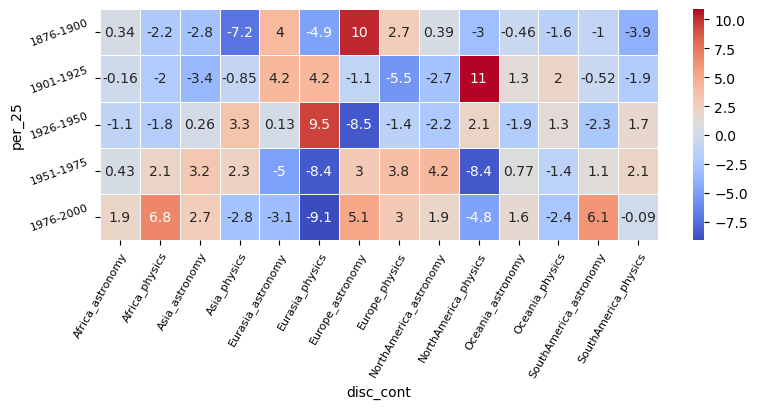

In [75]:
## Appliquer la fonction
bivariee_stats(D)